Sentence Classification using logistic regression Classifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from gensim.models.fasttext import FastText
#from sklearn.decomposition import PCA
from nltk.util import ngrams
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
import seaborn as sn
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from copy import deepcopy
from scipy import sparse


In [ ]:
# try to read it as pandas dataframe
df = pd.read_pickle("calls_ver2.pkl", compression=None)
N = len(df)
agent_duration_secs = []
agent_largest_monologue_secs = []
agent_words_per_minute = []
customer_duration_secs = []
customer_largest_monologue_secs = []
duration_secs = []
intents = []
interrupts_by_agent = []
interrupts_by_customer = []
overall_intent = []
patience_secs = []
switches = []
actor = [] 
dialogues = [] 
 
counter = 0
for i in range(N):
    j = df[i]
    overall_intent.append(j.overall_intent)
    agent_duration_secs.append(j.agent_duration_secs)
    agent_largest_monologue_secs.append(j.agent_largest_monologue_secs)
    agent_words_per_minute.append(j.agent_words_per_minute)
    customer_duration_secs.append(j.customer_duration_secs)
    customer_largest_monologue_secs.append(j.customer_largest_monologue_secs)
    duration_secs.append(j.duration_secs)
    interrupts_by_agent.append(j.interrupts_by_agent)
    interrupts_by_customer.append(j.interrupts_by_customer)
    patience_secs.append(j.patience_secs)
    switches.append(j.switches)
    #read the data of each segment
    seg = j.segments
    NN = len(seg)
    speaker = NN*[0]
    seg_intent = NN*[0]
    seg_sentence = [0]*NN
    for k in range(NN):
        speaker[k] = seg[k].actor
        seg_intent[k] = seg[k].intent 
        seg_sentence[k] = seg[k].sentence    
    actor.append(speaker)
    intents.append(seg_intent)
    dialogues.append(seg_sentence)

    
# gather info from all sentences
sent_actor = [item for sublist in actor for item in sublist]
sent_intent = [item for sublist in intents for item in sublist]
sentences = [item for sublist in dialogues for item in sublist]
#pro_sentences = [item for sublist in pro_dialogues for item in sublist]
words = [item for sublist in sentences for item in sublist]
#pro_words = [item for sublist in pro_sentences for item in sublist]
vocabulary = set(words)
#pro_vocabulary = set(pro_words)
print(len(vocabulary))
#print(len(pro_vocabulary))

arthra = ['ο', 'του', 'τον', 'οι', 'των', 'τουσ', 'η', 'τησ' ,'την', 'τη', 'τισ', 'το', 'τα', 'στα', 'στο', 'στον', 'στουσ']
prothemata = ['να', 'απο', 'από', 'και', 'επί', 'επι']
antwnumies = ['μου', 'με', 'σου', 'σε', 'σας','σασ']
staggering = ['α', 'αα', 'ε', 'εε', 'ο', 'οο', 'ω', 'ωω', 'ι','ιι' ,'ηη']
alla = ['ειναι', 'είναι', 'θα', 'για','ναι', 'καλημέρα', 'πώς', 'τι']
my_stopwords = arthra + prothemata + antwnumies + staggering + alla
print(len(my_stopwords))


5048
48


In [ ]:
# prepare the dialogue data 
x = []
for i in range(N):
    x.append(' '.join(sentences[i]))
y = deepcopy(sent_intent)


In [ ]:
# prepare the dialogue data 
def train_dev_test_splitter(X,Y,fraction=0.2,seed=1):
    x_nontest, x_test, y_nontest, y_test = train_test_split(X,Y,stratify=Y,random_state=seed, test_size=fraction)
    return x_nontest, y_nontest, x_test, y_test

x = []
for i in range(len(sentences)):
    x.append(' '.join(sentences[i]))
y = deepcopy(sent_intent)
exclude = [None, 'AGENT_HANDLE_SUPERVISOR', 'CUSTOMER_RESERVATION_CONFLICT', 'CUSTOMER_DEFINE_NAME', 'CUSTOMER_DEFINE_PHONE', 'AGENT_INFORM_STORE_DETAILS', 'AGENT_INFORM_RESERVATION_CONFLICT', 'AGENT_HANDLE_APOLOGIZE', 'AGENT_INFORM_NOTFOUND'] # maybe also 'CUSTOMER_INFORM_PRICING'
faults = 0
for i in range(len(sent_intent)):
    if sent_intent[i] in exclude:
        if 'agent' == sent_actor[i]:
            y[i] = 'AGENT_OTHER'
        elif 'customer' in sent_actor[i]:
            y[i] = 'CUSTOMER_OTHER'
        else:
            faults += 1


x_nontest, y_nontest, x_test, y_test = train_dev_test_splitter(x, y, fraction=0.15,seed=1)
nothing , actor_nontest, nothing2, actor_test = train_dev_test_splitter(x,sent_actor,fraction=0.15,seed=1)
xx_train, yy_train, x_dev, y_dev = train_dev_test_splitter(x_nontest, y_nontest, fraction=0.15,seed=1)
Counter(y)
labels = list(set(y))
# 72.25% train , 12.75% dev , 15% test => stratified split


In [ ]:
# define functions to make the code more pretty !
def my_vectorizer(max_ngram, max_feature, max_tf=0.95, min_tf=5, sublinear=True, stopwords=my_stopwords):
    return TfidfVectorizer(ngram_range=(1, max_ngram), max_features = max_feature, stop_words = stopwords ,max_df=max_tf, min_df=min_tf, sublinear_tf=sublinear)

def convert_tfidf_data(xtrain,xtest,vector_model):
    xtrain_tfidf = vector_model.fit_transform(xtrain)
    xtest_tfidf = vector_model.transform(xtest)
    return xtrain_tfidf, xtest_tfidf

def my_logistic(regularization_weight,clas='multinomial',solver='saga',iterations=200,regularizer= 'l2',):
    return LogisticRegression(multi_class=clas, C=regularization_weight, penalty = regularizer,solver=solver, max_iter=iterations, random_state=1,n_jobs=-1)

def evaluate_model(model,X,Y,xtest,ytest, f1_average= 'weighted' ,label=labels):
    model.fit(X,Y)
    predictions = model.predict(xtest)
    accuracy = accuracy_score(ytest, predictions)
    f1 = f1_score(ytest, predictions, average=f1_average, zero_division=0, labels = labels) # 'macro'  'micro'  'weighted'
    pred_prob = model.predict_proba(xtest)
    loss = log_loss(ytest, pred_prob, labels = labels)
    b_acc = balanced_accuracy_score(ytest, predictions)
    return accuracy, f1, loss, b_acc

def undersampling(xx_train2, yy_train2, other_limit=0.1, agent_limit=0.1):
    y_train2 = []
    x_train2 = []
    counter1_a, counter1_c, counter2 = 0 , 0, 0
    other_a, other_c = 0,0
    agent = 0
    for i in yy_train2:
        if i == 'AGENT_OTHER':
            other_a += 1
        elif i == 'CUSTOMER_OTHER':
            other_c +=1
        elif i == 'AGENT_DEFINE_DATETIME':
            agent += 1
        else:
            pass
    num_other_a = int(other_a*other_limit)
    num_other_c = int(other_c*other_limit)
    num_agent = int(agent*agent_limit)
    for i in range(len(yy_train2)):
        if yy_train2[i] == 'AGENT_OTHER':
            counter1_a += 1
            if counter1_a <= num_other_a:
                x_train2.append(xx_train2[i])
                y_train2.append(yy_train2[i])
            else:
                pass
        
        elif yy_train2[i] == 'CUSTOMER_OTHER':
            counter1_c += 1
            if counter1_c <= num_other_c:
                x_train2.append(xx_train2[i])
                y_train2.append(yy_train2[i])
            else:
                pass
        
        elif yy_train2[i] == 'AGENT_DEFINE_DATETIME':
            counter2 += 1
            if counter2 <= num_agent:
                x_train2.append(xx_train2[i])
                y_train2.append(yy_train2[i])
            else:
                pass
        else:
            x_train2.append(xx_train2[i])
            y_train2.append(yy_train2[i])

    return x_train2, y_train2



In [ ]:
Counter(y_nontest)

Counter({'CUSTOMER_OTHER': 6180,
         'AGENT_OTHER': 5447,
         'AGENT_INFORM_DOCUMENTS': 249,
         'AGENT_DEFINE_RESERVATION': 127,
         'CUSTOMER_DEFINE_PLATES': 91,
         'AGENT_DEFINE_DATETIME': 936,
         'CUSTOMER_COMPLAINT': 138,
         'CUSTOMER_DEFINE_DATETIME': 363,
         'CUSTOMER_RESERVATION': 108,
         'AGENT_DEFINE_PLATES': 303,
         'CUSTOMER_DEFINE_STORE': 73,
         'AGENT_INFORM_PRICING': 221,
         'AGENT_DEFINE_PHONE': 168,
         'AGENT_DEFINE_STORE': 134,
         'CUSTOMER_INFORM_PRICING': 61,
         'AGENT_DEFINE_NAME': 160})

In [ ]:
Counter(yy_train)

Counter({'AGENT_INFORM_DOCUMENTS': 212,
         'CUSTOMER_OTHER': 5253,
         'AGENT_OTHER': 4630,
         'AGENT_DEFINE_PLATES': 257,
         'AGENT_DEFINE_NAME': 136,
         'AGENT_DEFINE_RESERVATION': 108,
         'CUSTOMER_DEFINE_PLATES': 77,
         'CUSTOMER_DEFINE_DATETIME': 308,
         'AGENT_DEFINE_DATETIME': 796,
         'CUSTOMER_COMPLAINT': 117,
         'AGENT_DEFINE_PHONE': 143,
         'CUSTOMER_RESERVATION': 92,
         'AGENT_INFORM_PRICING': 188,
         'AGENT_DEFINE_STORE': 114,
         'CUSTOMER_DEFINE_STORE': 62,
         'CUSTOMER_INFORM_PRICING': 52})

In [ ]:
Counter(y_dev)

Counter({'CUSTOMER_OTHER': 927,
         'AGENT_OTHER': 817,
         'AGENT_DEFINE_PHONE': 25,
         'AGENT_DEFINE_DATETIME': 140,
         'AGENT_DEFINE_RESERVATION': 19,
         'AGENT_DEFINE_NAME': 24,
         'AGENT_INFORM_DOCUMENTS': 37,
         'AGENT_DEFINE_PLATES': 46,
         'AGENT_INFORM_PRICING': 33,
         'CUSTOMER_RESERVATION': 16,
         'AGENT_DEFINE_STORE': 20,
         'CUSTOMER_DEFINE_DATETIME': 55,
         'CUSTOMER_DEFINE_PLATES': 14,
         'CUSTOMER_COMPLAINT': 21,
         'CUSTOMER_INFORM_PRICING': 9,
         'CUSTOMER_DEFINE_STORE': 11})

In [ ]:
Counter(y_test)

Counter({'AGENT_OTHER': 961,
         'AGENT_DEFINE_STORE': 24,
         'AGENT_DEFINE_DATETIME': 165,
         'CUSTOMER_OTHER': 1091,
         'CUSTOMER_DEFINE_DATETIME': 64,
         'AGENT_INFORM_PRICING': 39,
         'AGENT_DEFINE_PLATES': 53,
         'CUSTOMER_COMPLAINT': 25,
         'AGENT_INFORM_DOCUMENTS': 44,
         'CUSTOMER_INFORM_PRICING': 11,
         'AGENT_DEFINE_NAME': 28,
         'AGENT_DEFINE_PHONE': 30,
         'CUSTOMER_DEFINE_STORE': 13,
         'CUSTOMER_RESERVATION': 19,
         'AGENT_DEFINE_RESERVATION': 22,
         'CUSTOMER_DEFINE_PLATES': 16})

In [ ]:
po, example = undersampling(xx_train,yy_train, other_limit = 0.1, agent_limit = 0.5)   
Counter(example)

Counter({'AGENT_INFORM_DOCUMENTS': 212,
         'CUSTOMER_OTHER': 525,
         'AGENT_OTHER': 463,
         'AGENT_DEFINE_PLATES': 257,
         'AGENT_DEFINE_NAME': 136,
         'AGENT_DEFINE_RESERVATION': 108,
         'CUSTOMER_DEFINE_PLATES': 77,
         'CUSTOMER_DEFINE_DATETIME': 308,
         'AGENT_DEFINE_DATETIME': 398,
         'CUSTOMER_COMPLAINT': 117,
         'AGENT_DEFINE_PHONE': 143,
         'CUSTOMER_RESERVATION': 92,
         'AGENT_INFORM_PRICING': 188,
         'AGENT_DEFINE_STORE': 114,
         'CUSTOMER_DEFINE_STORE': 62,
         'CUSTOMER_INFORM_PRICING': 52})

In [ ]:
# define all the parameters to be fine-tuned
ngram_range = [1,2]
max_features = [200,400,600,800]
max_tf = [0.3, 0.45, 0.6]
min_tf = [0.01,0.05,0.1]
sublinear = [True,False]
logistic_class = ['multinomial']
regularizer_strength = [0.1, 0.5, 1.]
solver = ['lbfgs']
logistic_penalty = ['l2']
l_other = [0.04,0.07,0.1]
l_agent = [0.4,0.5]

In [ ]:
accuracies, f1s, losses, b_accs = [], [], [], []
best_loss , best_acc , best_f1, best_b_acc = 1,0,0,0
counter = 0
for ee in l_other:
    for eee in l_agent:
        x_train, y_train = undersampling(xx_train,yy_train, other_limit = ee, agent_limit = eee)   
        for a in ngram_range:
            for b in max_features:
                for c in max_tf:
                    for d in min_tf:
                        for e in sublinear:
                            vectorizer = my_vectorizer(a,b,c,d,e) 
                            train_tfidf, dev_tfidf = convert_tfidf_data(x_train,x_dev,vectorizer)
                            for f in logistic_class:
                                for g in regularizer_strength:
                                    for h in logistic_penalty: 
                                        log = my_logistic(g, regularizer=h, clas=f)
                                        ac,fscore,l, b_ac = evaluate_model(log,train_tfidf,y_train,dev_tfidf,y_dev)                                
                                        accuracies.append(ac)
                                        f1s.append(fscore)
                                        losses.append(l)
                                        b_accs.append(b_ac)

                                        counter += 1
                                        if counter%500 == 0:
                                            print("\n\n\n\nall ok till ", counter)

                                        if l < best_loss:
                                            best_loss = l
                                            loss_ngram, loss_features, loss_maxtf, loss_mintf, loss_sublinear, loss_class, loss_strength, loss_penalty,loss_other,loss_agent = a,b,c,d,e,f,g,h,ee,eee
                                        if ac > best_acc:
                                            best_acc = ac
                                            acc_ngram, acc_features, acc_maxtf, acc_mintf, acc_sublinear, acc_class, acc_strength, acc_penalty,acc_other,acc_agent = a,b,c,d,e,f,g,h,ee,eee
                                        if b_ac > best_b_acc:
                                            best_b_acc = b_ac
                                            b_acc_ngram, b_acc_features, b_acc_maxtf, b_acc_mintf, b_acc_sublinear, b_acc_class, b_acc_strength, b_acc_penalty, b_acc_other, b_acc_agent = a,b,c,d,e,f,g,h,ee,eee
                                        if fscore > best_f1:
                                            best_f1 = fscore
                                            f1_ngram, f1_features, f1_maxtf, f1_mintf, f1_sublinear, f1_class, f1_strength, f1_penalty,f1_other,f1_agent = a,b,c,d,e,f,g,h,ee,eee






all ok till  500




all ok till  1000




all ok till  1500




all ok till  2000




all ok till  2500


In [ ]:
#print(best_loss)
#for i in [loss_ngram, loss_features, loss_maxtf, loss_mintf, loss_sublinear, loss_strength,loss_other,loss_agent]:
 #   print(i)
print()

print(best_acc)
for i in [acc_ngram, acc_features, acc_maxtf, acc_mintf, acc_sublinear, acc_strength,acc_other,acc_agent]:
    print(i)
print()

print(best_b_acc)
for i in [b_acc_ngram, b_acc_features, b_acc_maxtf, b_acc_mintf, b_acc_sublinear, b_acc_strength,b_acc_other,b_acc_agent]:
    print(i)
print()

print(best_f1)
for i in [f1_ngram, f1_features, f1_maxtf, f1_mintf, f1_sublinear, f1_strength,f1_other,f1_agent]:
    print(i)
print()



0.6341463414634146
2
200
0.3
0.01
True
0.1
0.1
0.4

0.6496490938656203
1
200
0.3
0.01
True
1.0
0.04
0.4

0.6183374197856035
2
200
0.3
0.01
True
0.1
0.1
0.4



final accuracy  0.5205374280230326
final balanced accuracy  0.6448308270720782
final f1 weighted  0.5341084491011043
final log-loss  1.602082028151475


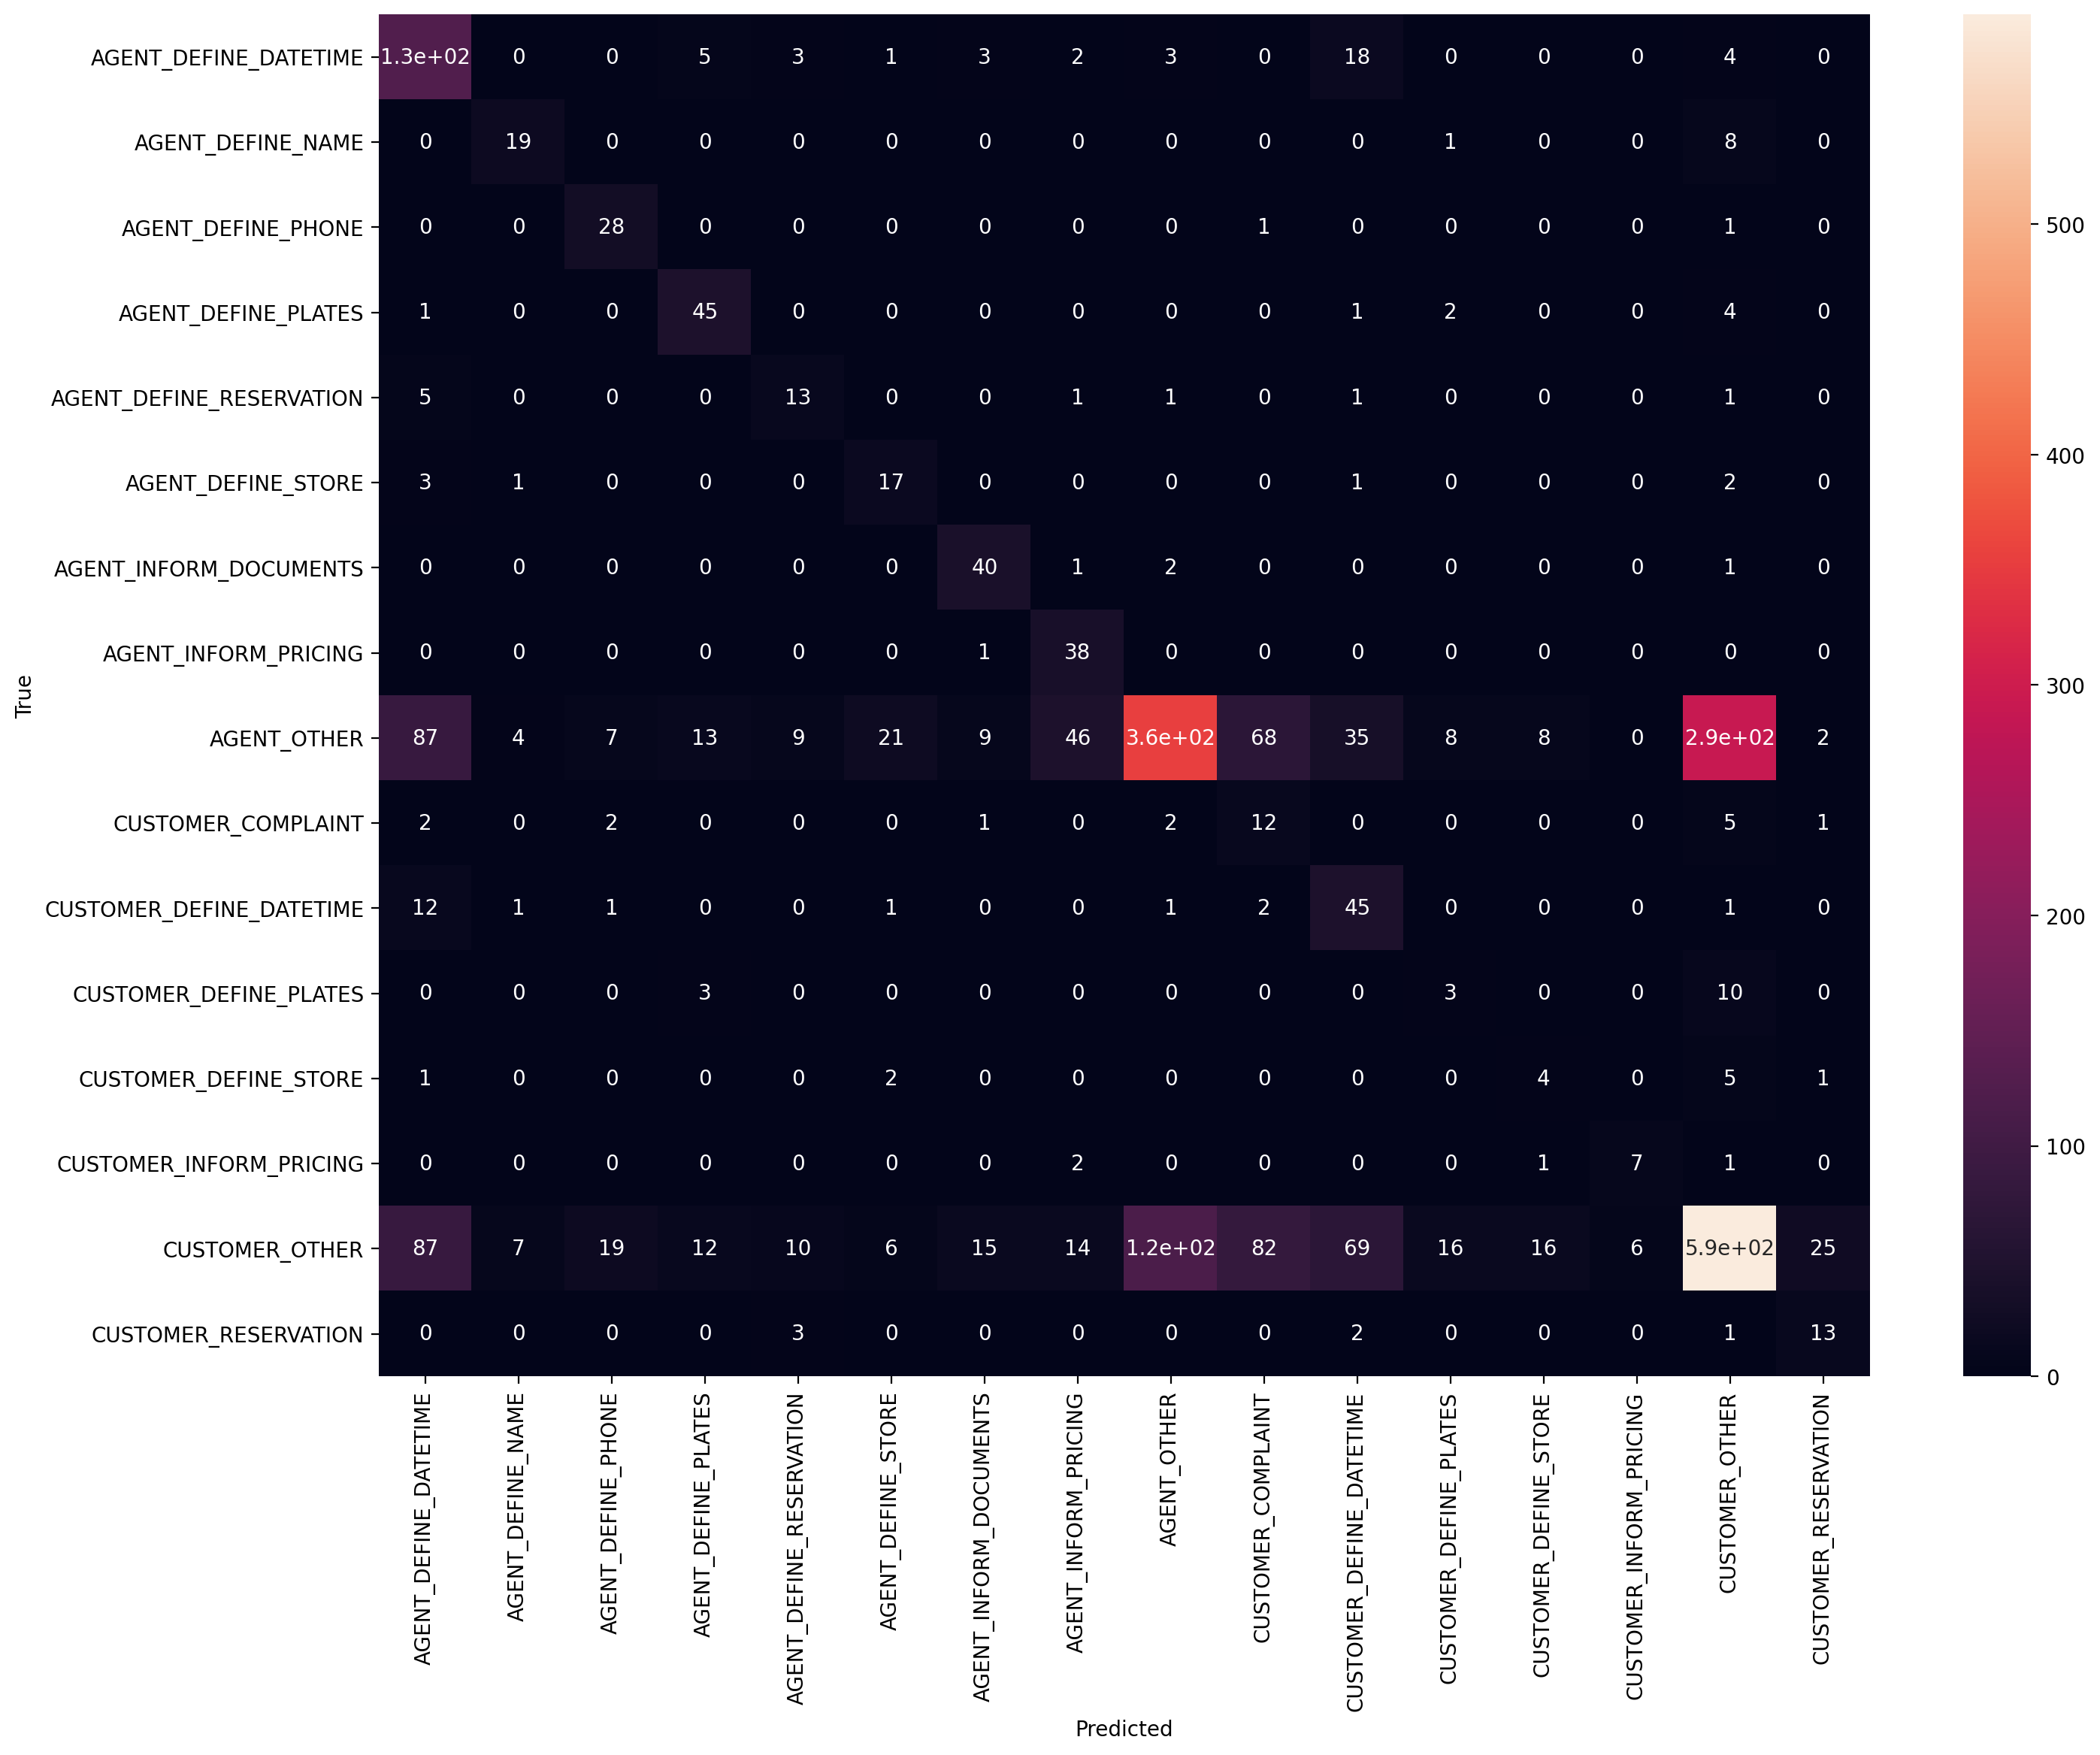

In [ ]:
# according to best f1
final_vectorizer = my_vectorizer(b_acc_ngram,b_acc_features,b_acc_maxtf,b_acc_mintf,b_acc_sublinear) 
#final_vectorizer = my_vectorizer(1,1500,0.9,1,True)
final_xtrain, final_ytrain = undersampling(x_nontest,y_nontest, other_limit=b_acc_other, agent_limit=b_acc_agent)
final_train_tfidf, final_test_tfidf = convert_tfidf_data(final_xtrain,x_test,final_vectorizer)
final_log = my_logistic(b_acc_strength, regularizer=b_acc_penalty, solver='saga')
#final_log = my_logistic(0.5,regularizer='l2')
ac,fscore,l,b_ac = evaluate_model(final_log,final_train_tfidf,final_ytrain,final_test_tfidf,y_test)                                

print("final accuracy ", ac)
print("final balanced accuracy ", b_ac)
print("final f1 weighted ", fscore)
print("final log-loss ", l)

final_log.fit(final_train_tfidf,final_ytrain)
predictions = final_log.predict(final_test_tfidf)
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions, name='Predicted')
dialogue_correlation = pd.crosstab(y_true, y_pred)
#print(dialogue_correlation)
#print()

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 200 
sn.heatmap(dialogue_correlation, annot=True)
plt.show()


In [ ]:
faults2 = 0
pred_probabilities = final_log.predict_proba(final_test_tfidf)
logistic_labels = list(final_log.classes_)
# 9 agent classes and 7 customer
pred_onehot = np.zeros((len(y_test),len(labels)))
for i in range(len(y_test)):
    if 'AGENT' in y_test[i]:
        k = np.argmax(pred_probabilities[i][:9])
        pred_onehot[i][k] = 1
    elif 'CUSTOMER' in y_test[i]:
        k = np.argmax(pred_probabilities[i][9:])
        k = k + 9
        pred_onehot[i][k] = 1
    else:
        faults2 += 1

pred_onehot_labels = []
for i in range(len(pred_onehot)):
    for j in range(len(logistic_labels)):
        if pred_onehot[i][j] == 1:
            pred_onehot_labels.append(logistic_labels[j])


In [ ]:
print("accuracy: " , accuracy_score(y_test, pred_onehot_labels))
print("balanced accuracy: ", balanced_accuracy_score(y_test, pred_onehot_labels))
print("f1 :  ", f1_score(y_test, pred_onehot_labels, average='weighted', zero_division=0, labels = logistic_labels)) # 'macro'  'micro'  'weighted'
y_pred2 = pd.Series(pred_onehot_labels, name='Predicted')
dialogue_correlation = pd.crosstab(y_true, y_pred2)
#print(dialogue_correlation)
#print()


accuracy:  0.7251439539347408
balanced accuracy:  0.7294586536889949
f1 :   0.7606100630618308


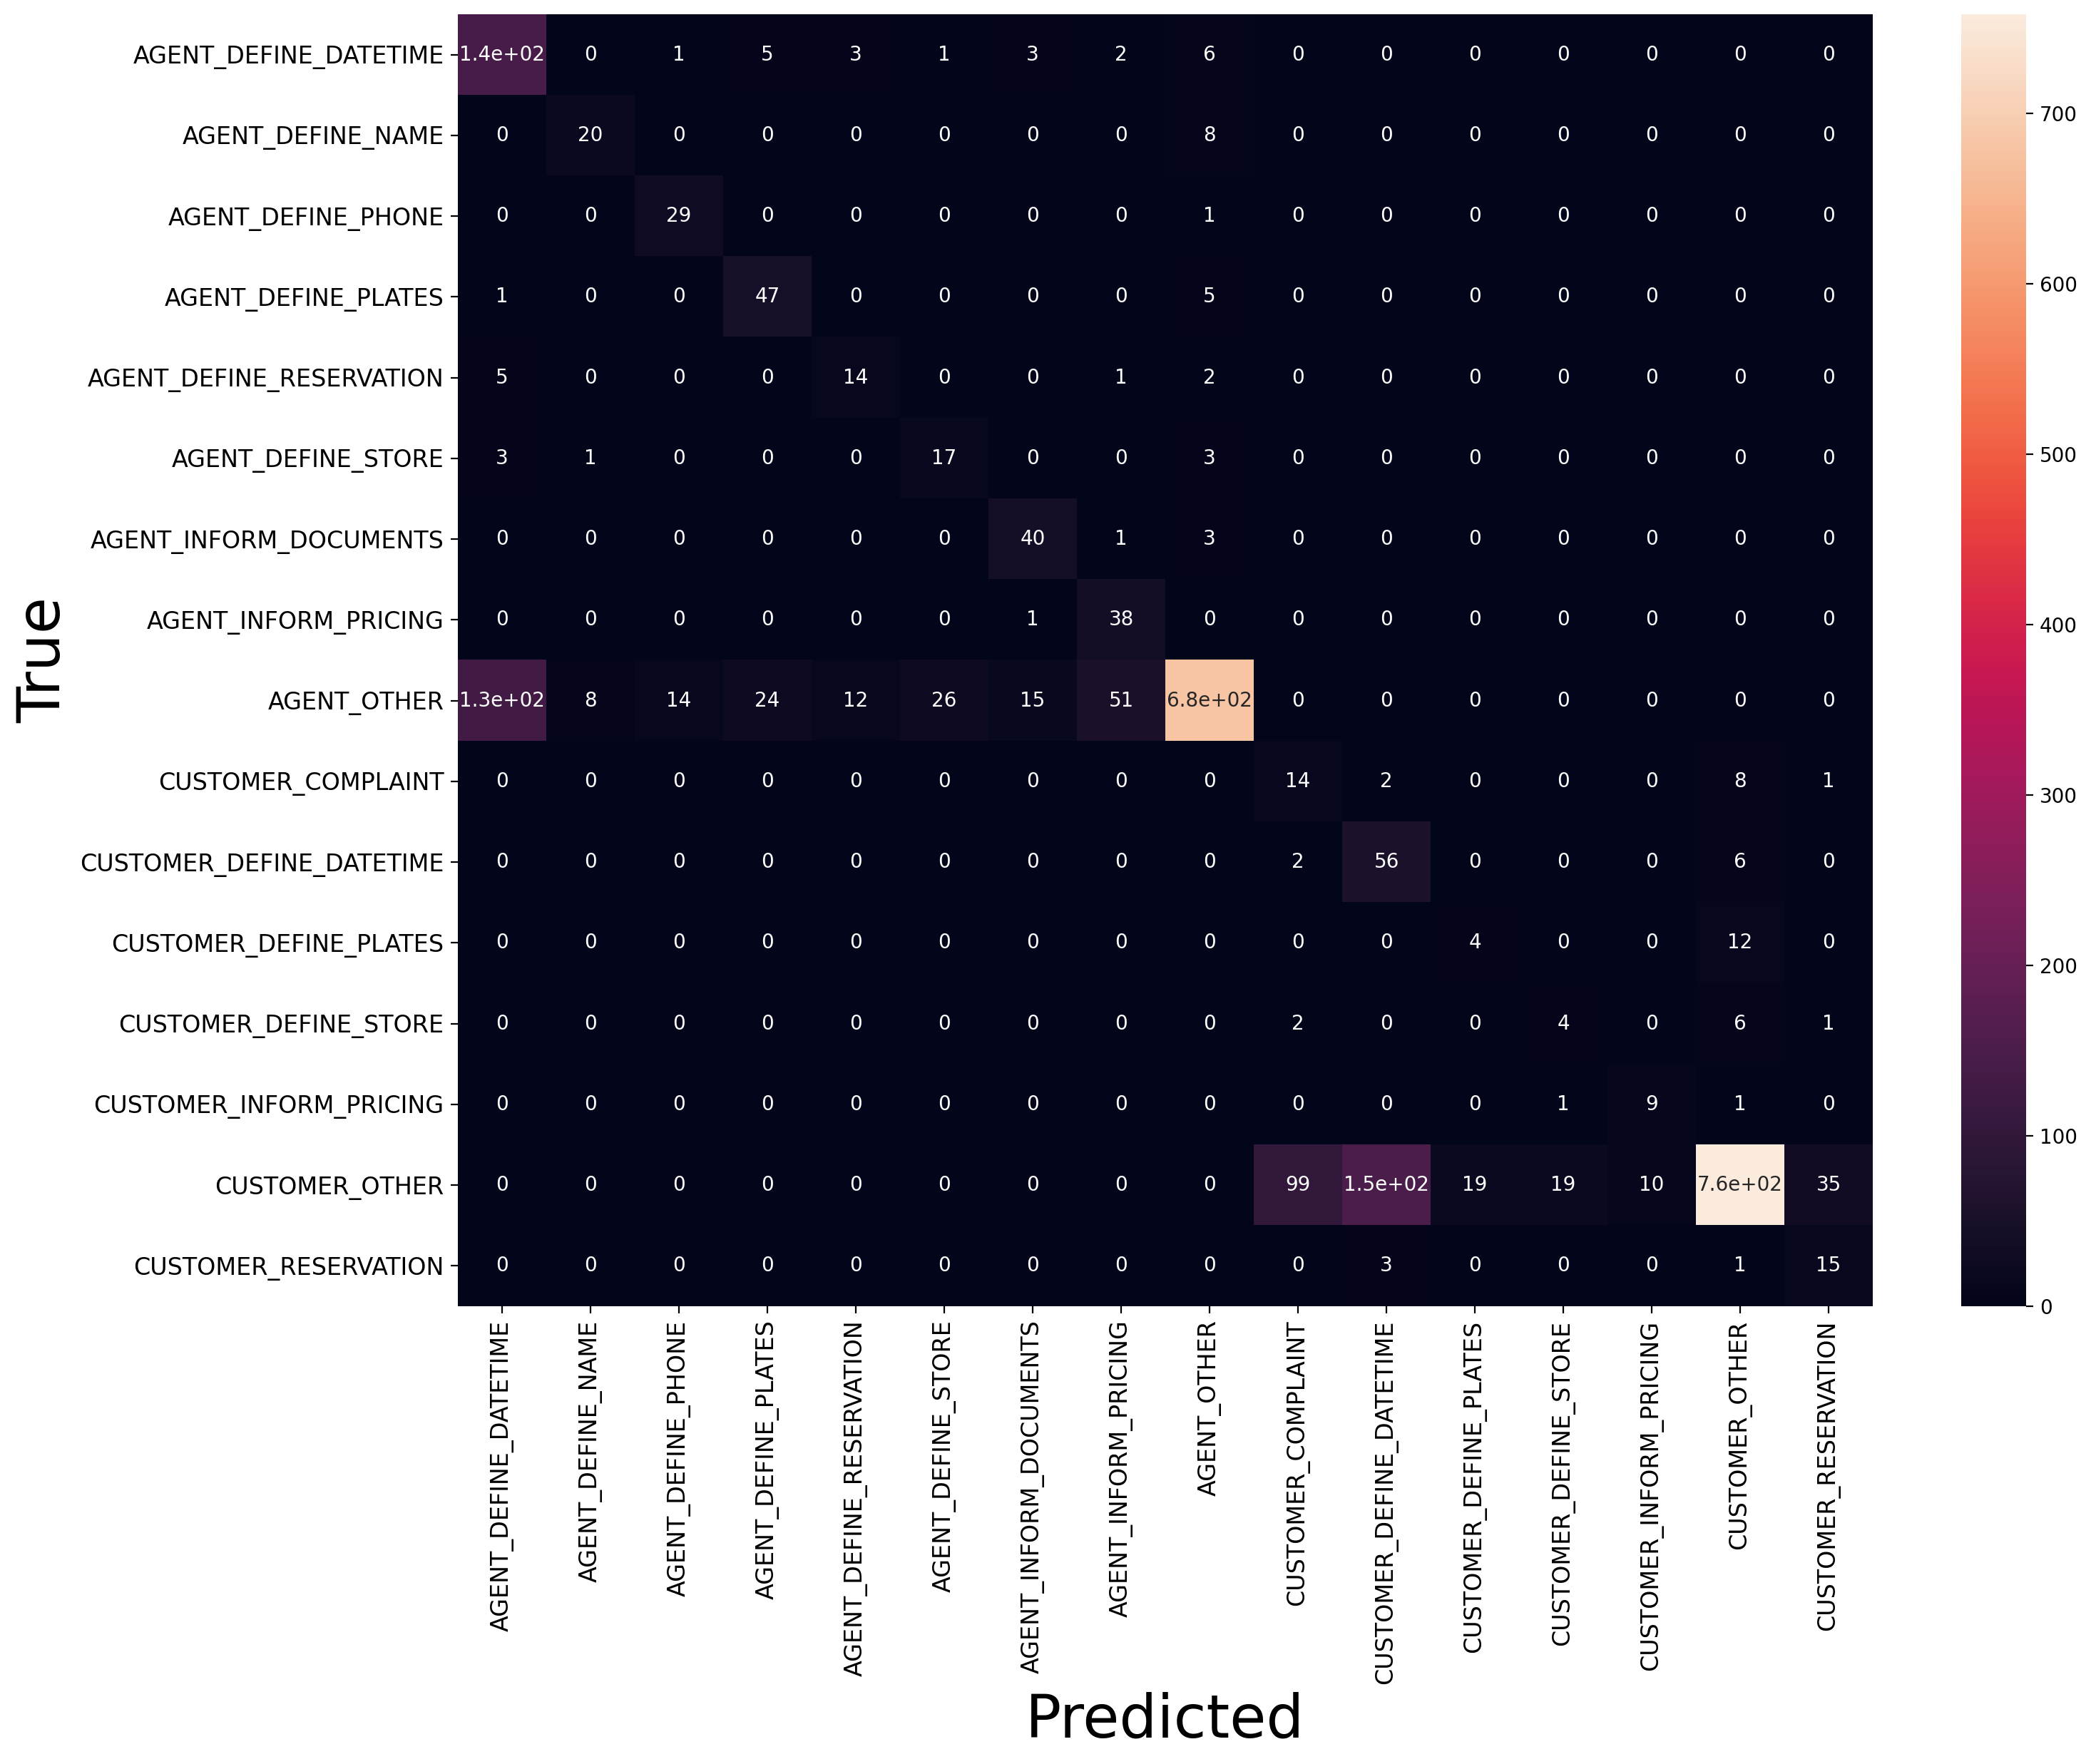

In [ ]:
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 200 
plt.ylabel("po",fontsize = 30)
plt.xlabel("po",fontsize = 30)
res = sn.heatmap(dialogue_correlation, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
plt.show()


#accuracy:  0.7244457241577886
#balanced accuracy:  0.7301353877268864
#f1 :   0.7624311091804887

In [ ]:
import random
import copy
def stratified_learning_curve(xx, yy, other=b_acc_other, agents = b_acc_agent, actor2=sent_actor, num_cross=10,  title='Fold Cross-Validation', metric='f1_weighted', vectorizer = final_vectorizer, estimator = final_log):
    fold = 6
    b, bb = [], []
    plt.figure()
    plt.title(str(fold)+ '-' + title)
    plt.xlabel("Training fraction")
    plt.ylabel(metric)
    train_scores, test_scores = [], []
    train_sizes=np.linspace(0.2, 1.0, 5)

    #kfold = StratifiedKFold(n_splits=fold, shuffle=True,random_state=1)    
    for i in range(num_cross):
        xx = np.array(xx)
        yy = np.array(yy)
        xtrain, ytrain, xtest, ytest = train_dev_test_splitter(xx, yy, fraction=0.166,seed=i)        
        x_rest1, y_rest1, x_part1, y_part1 = train_dev_test_splitter(xtrain, ytrain, fraction=0.2,seed=i+1)
        x_rest2, y_rest2, x_part2, y_part2 = train_dev_test_splitter(x_rest1, y_rest1, fraction=0.25,seed=i+2)
        x_rest3, y_rest3, x_part3, y_part3 = train_dev_test_splitter(x_rest2, y_rest2, fraction=0.33,seed=i+3)
        x_part5, y_part5, x_part4, y_part4 = train_dev_test_splitter(x_rest3, y_rest3, fraction=0.5,seed=i+4)

        y_partitions = [y_part1,y_part2,y_part3,y_part4,y_part5]
        x_partitions = [x_part1,x_part2,x_part3,x_part4,x_part5]
        score_tr, score_te = [], []
        for j in range(fold-1):
            if j == 0:
                yyy = y_partitions[0]
                xxx = x_partitions[0]
            else:
                yyy = np.concatenate([y_partitions[j],yyy])
                xxx = np.concatenate([x_partitions[j],xxx])

            xxx_train, yyy_train = undersampling(xxx,yyy, other_limit = other, agent_limit = agents)   
            train_tfidf, test_tfidf = convert_tfidf_data(xxx_train,xtest,vectorizer)
            
            final_log = copy.copy(estimator)
            final_log.fit(train_tfidf,yyy_train)
            train_pred = final_log.predict(train_tfidf)
            test_pred = final_log.predict(test_tfidf)
            test_probs = final_log.predict_proba(test_tfidf)
            train_probs = final_log.predict_proba(train_tfidf)
            
            b.append(train_pred)
            bb.append(yyy_train)
            if metric == 'f1_weighted':
                score_te.append(f1_score(ytest,test_pred, average='weighted'))
                score_tr.append(f1_score(yyy_train,train_pred, average='weighted'))
            elif metric == 'loss':
                score_te.append(log_loss(ytest,test_probs))
                score_tr.append(log_loss(yyy_train,train_probs))
            else:
                score_te.append(accuracy_score(ytest,test_pred))
                score_tr.append(accuracy_score(yyy_train,train_pred))
        train_scores.append(score_tr)
        test_scores.append(score_te)

    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",label="Test score")
    if metric == 'loss':
        plt.legend(loc="upper right")
    else:
        plt.legend(loc="lower right")        
    return plt


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

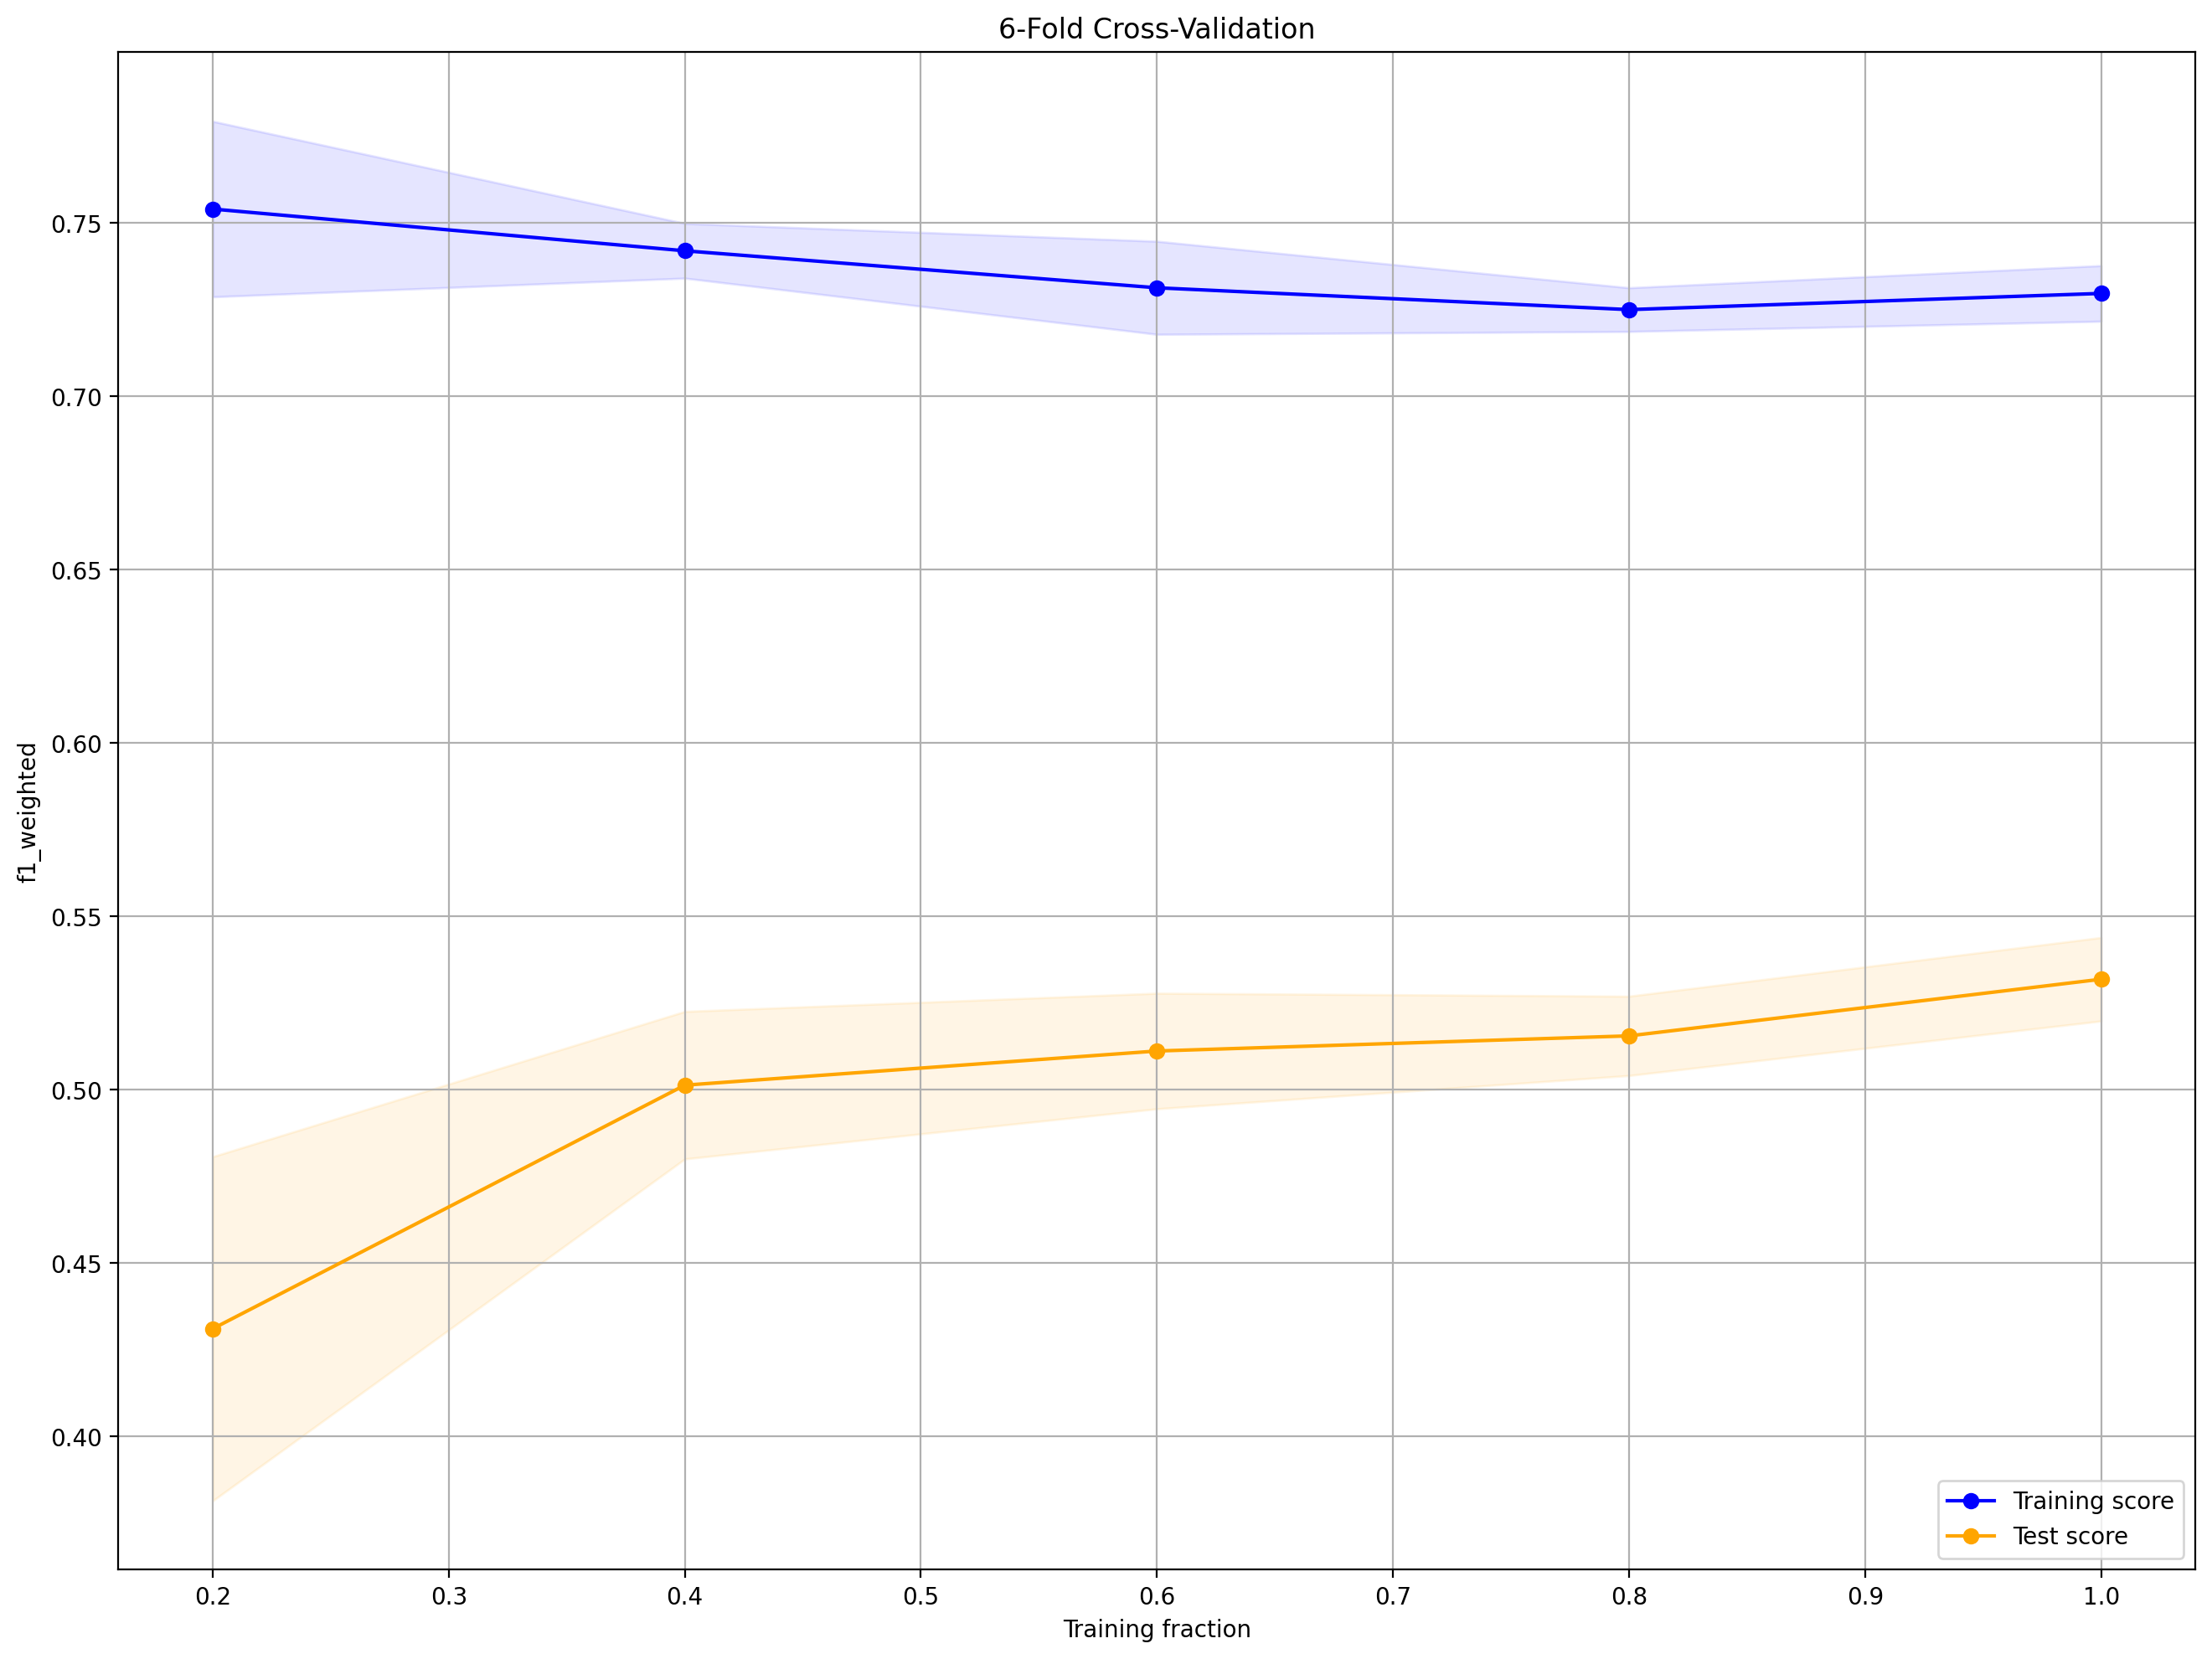

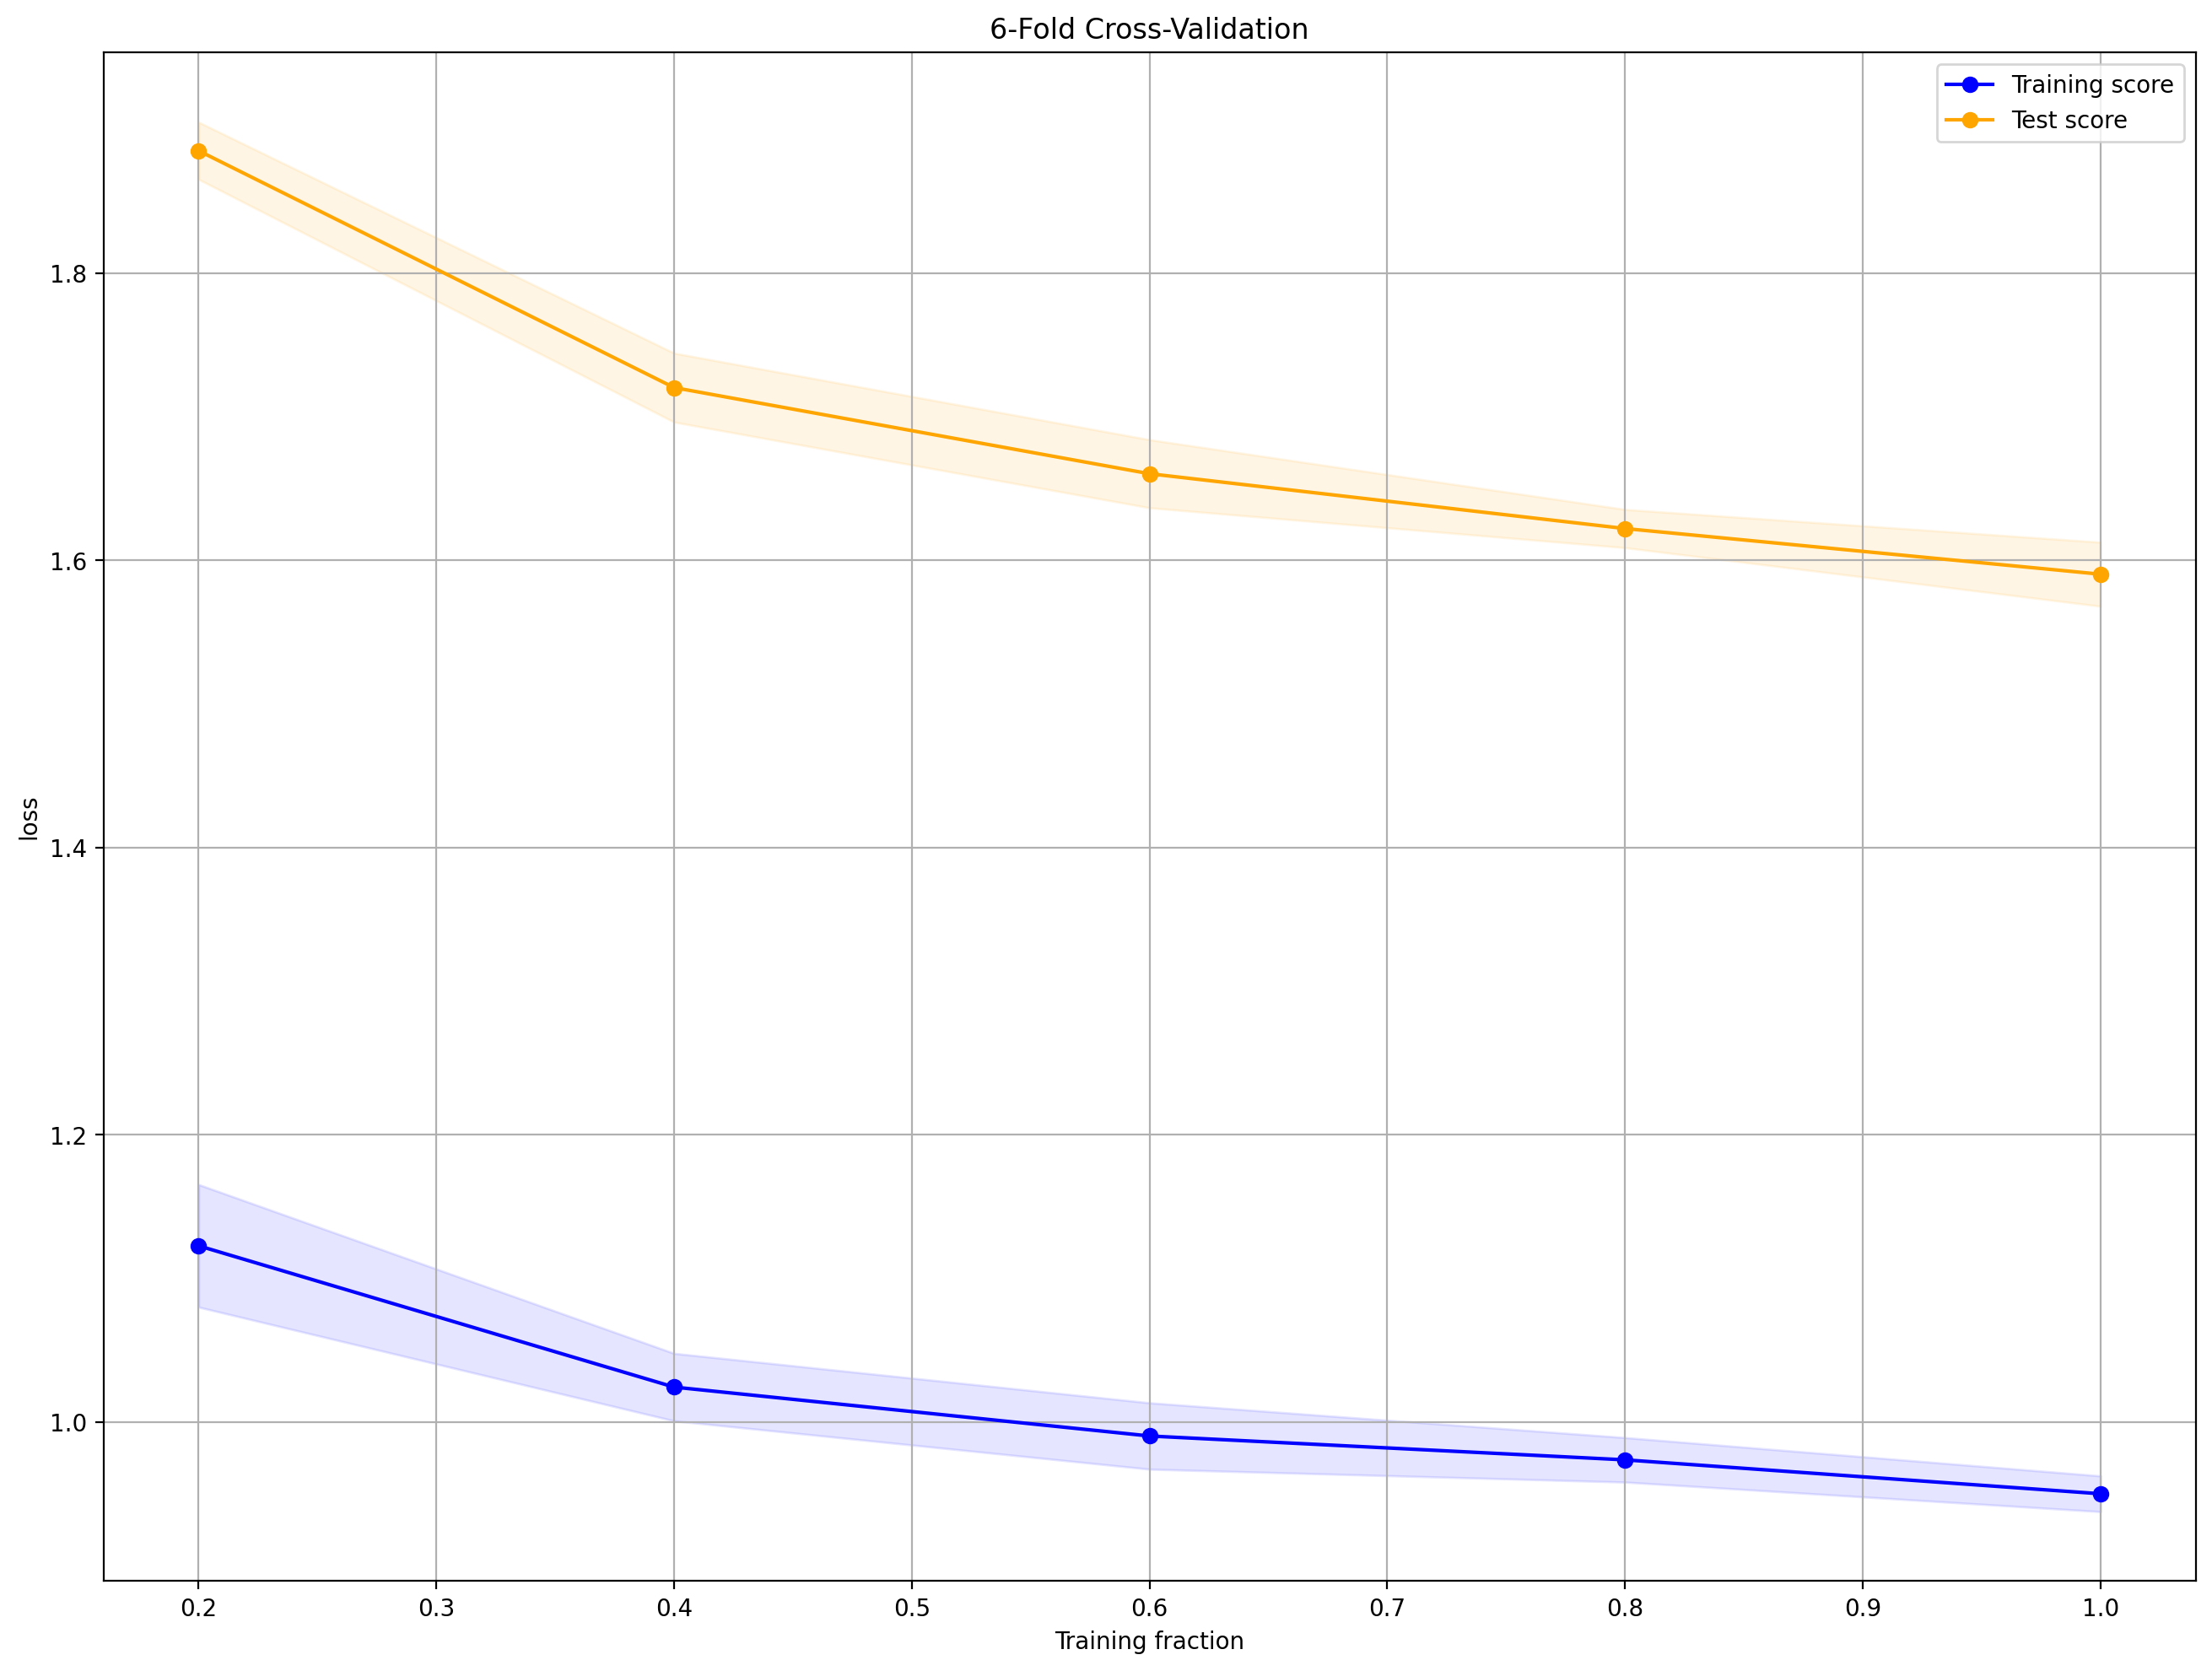

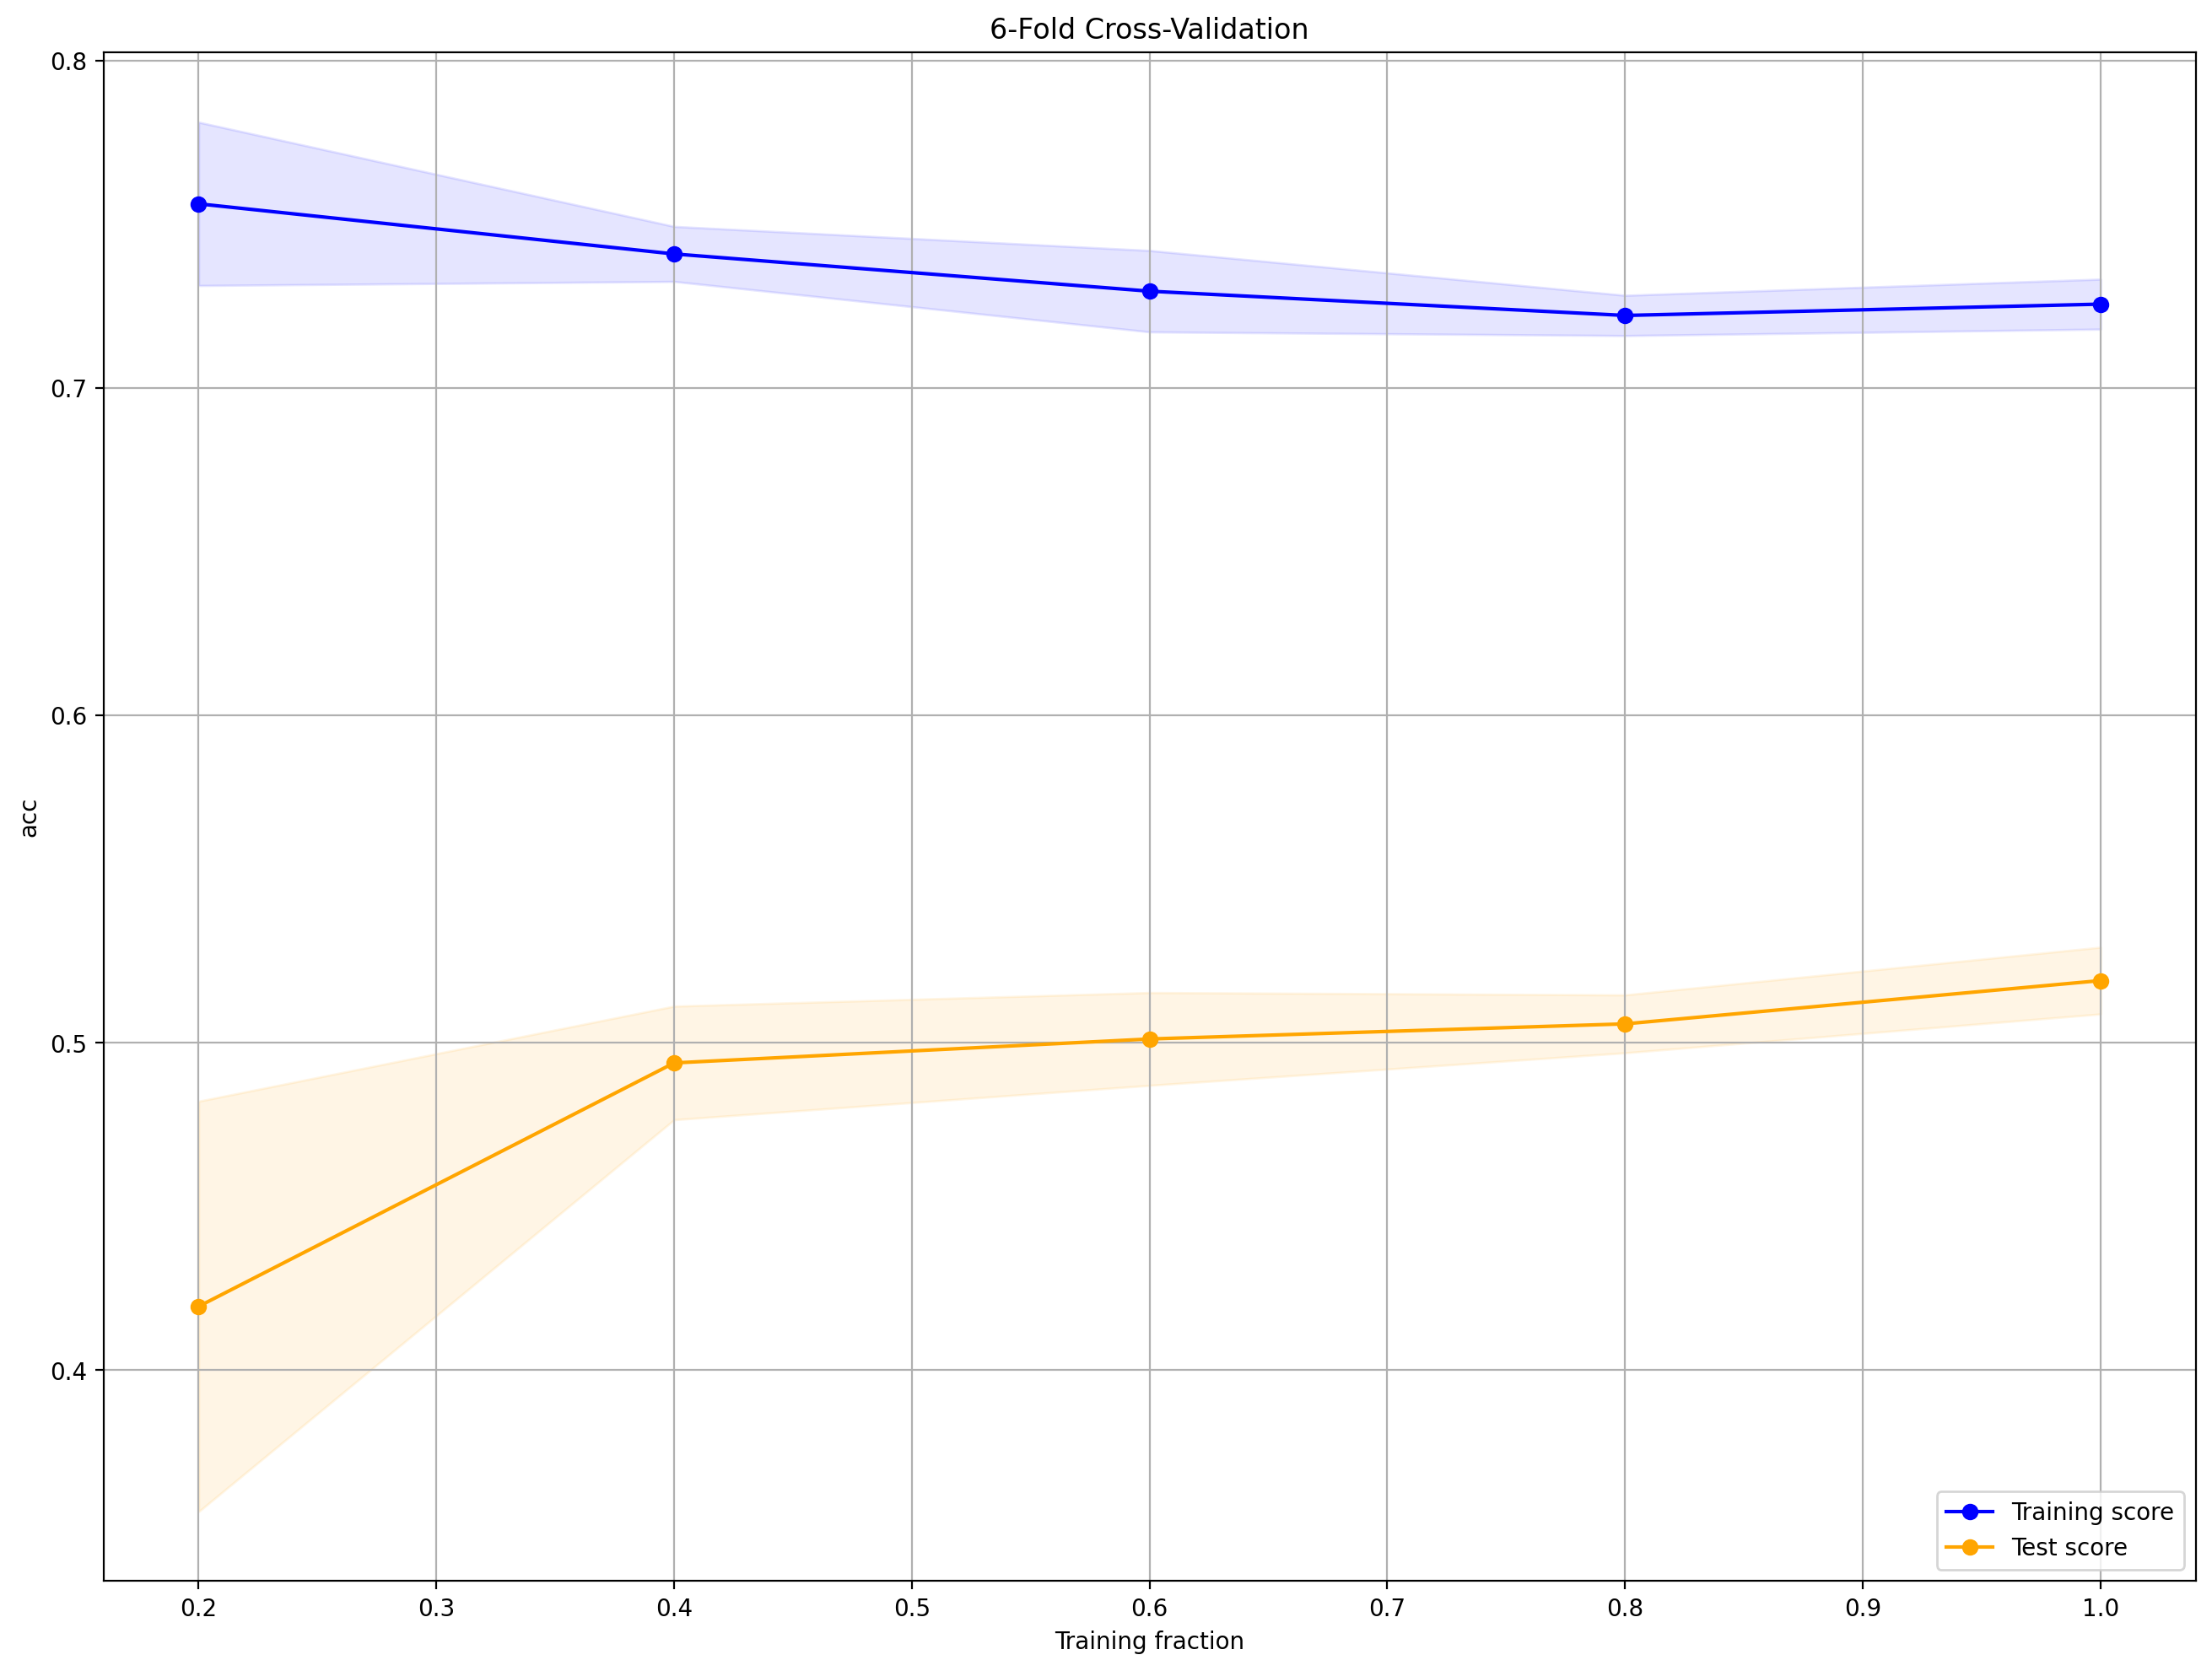

In [ ]:
stratified_learning_curve(x,y, vectorizer = final_vectorizer, estimator = final_log)
stratified_learning_curve(x,y, vectorizer = final_vectorizer, estimator = final_log, metric='loss')
stratified_learning_curve(x,y, vectorizer = final_vectorizer, estimator = final_log, metric='acc')
